### _final vs version3: pre-allocated tables, input data type declaration, macors @views and @. and 'fftconv' instead of classic 'conv' for a convolution.

Learning times:
1) Before modifications: 6 epochs: 9m 10s, 3 epochs: 4min 10sek
2) After tables preallocation: 6 epochs: 9m 4s, 3 epochs: 4m 5s
3) +macros: @views and @.: 6 epochs: 8m 8s, 3 epochs: 4m 3s 
4) +input data type declaration: 6 epochs: 7m 51s, 3 epochs: 3m 54s
5) with fftconv: 6 epochs: 7m 17s, 3 epochs: 3m 34s

Comparing to version3 learning time for 30 epochs has been reduced from 55m to 38m; after implementing fast fourier transform convolution it was reduced to 34min

### Structures
Definition of basic structures for computational graph

In [2]:
using LinearAlgebra

In [3]:
abstract type GraphNode end
abstract type Operator <: GraphNode end

struct Constant{T} <: GraphNode
    output :: T
end

mutable struct Variable <: GraphNode
    output :: Any
    gradient :: Any
    name :: String
    Variable(output; name="?") = new(output, nothing, name)
end

mutable struct ScalarOperator{F} <: Operator
    inputs :: Any
    output :: Any
    gradient :: Any
    name :: String
    ScalarOperator(fun, inputs...; name="?") = new{typeof(fun)}(inputs, nothing, nothing, name)
end

mutable struct BroadcastedOperator{F} <: Operator
    inputs :: Any
    output :: Any
    gradient :: Any
    name :: String
    BroadcastedOperator(fun, inputs...; name="?") = new{typeof(fun)}(inputs, nothing, nothing, name)
end

In [4]:
import Base: show, summary
show(io::IO, x::ScalarOperator{F}) where {F} = print(io, "op ", x.name, "(", F, ")");
show(io::IO, x::BroadcastedOperator{F}) where {F} = print(io, "op.", x.name, "(", F, ")");
show(io::IO, x::Constant) = print(io, "const ", x.output)
show(io::IO, x::Variable) = begin
    print(io, "var ", x.name);
    print(io, "\n ┣━ ^ "); summary(io, x.output)
    print(io, "\n ┗━ ∇ ");  summary(io, x.gradient)
end

show (generic function with 282 methods)

In [5]:
function visit(node::GraphNode, visited, order)
    if node ∈ visited
    else
        push!(visited, node)
        push!(order, node)
    end
    return nothing
end
    
function visit(node::Operator, visited, order)
    if node ∈ visited
    else
        push!(visited, node)
        for input in node.inputs
            visit(input, visited, order)
        end
        push!(order, node)
    end
    return nothing
end

function topological_sort(head::GraphNode)
    visited = Set()
    order = Vector()
    visit(head, visited, order)
    return order
end

topological_sort (generic function with 1 method)

### Forward pass

In [6]:
reset!(node::Constant) = nothing
reset!(node::Variable) = node.gradient = nothing
reset!(node::Operator) = node.gradient = nothing
#resety gradientu stałej lub gradientów węzłów na zero

compute!(node::Constant) = nothing
compute!(node::Variable) = nothing
compute!(node::Operator) =
    node.output = forward(node, [input.output for input in node.inputs]...)
#wywolanie forward dla węzła, wynik to wartość węzła (przejscie w przód przy alg rożniczkowania wstecznego)

function forward!(order::Vector)
    for node in order
        compute!(node) #obliczenie wart. węzła
        reset!(node) #reset poprzedniego gradientu do zera
    end
    return last(order).output #zwrócenie ostatniej wartości węzła (szczyt grafu)
end

forward! (generic function with 1 method)

### Backward pass

In [7]:
update!(node::Constant, gradient) = nothing
update!(node::GraphNode, gradient) = if isnothing(node.gradient)
    node.gradient = gradient else node.gradient .+= gradient
end
#dla stałej gradient=nothing, a dla węzła mamy gradient, gdy jest to pierwsze obliczenie gradientu
#lub .+= (dodanie) gradientu do już posiadanej wartości

function backward!(order::Vector; seed=1.0) #przyjmuje wektor posortowanych topologicznie węzłów
    result = last(order)
    result.gradient = seed
    @assert length(result.output) == 1 "Gradient is defined only for scalar functions"
    for node in reverse(order)
        backward!(node)
    end
    return nothing
end
#funkcja przechodzi graf w tył obliczając gradienty, wywołując funkcje backward

function backward!(node::Constant) end
function backward!(node::Variable) end
function backward!(node::Operator)
    inputs = node.inputs
    gradients = backward(node, [input.output for input in inputs]..., node.gradient)
    for (input, gradient) in zip(inputs, gradients)
        update!(input, gradient)
    end
    return nothing
end

backward! (generic function with 4 methods)

### Implemented operations

#### Broadcasted operators
The operations act on vectors of values so, the gradients are computed as vector-jacobian-products.

In [8]:
import Base: *
# x * y (aka matrix multiplication)
*(A::GraphNode, x::GraphNode) = BroadcastedOperator(mul!, A, x)
forward(::BroadcastedOperator{typeof(mul!)}, A::Matrix{Float32}, x::Vector{Float32}) = return A * x
backward(::BroadcastedOperator{typeof(mul!)}, A::Matrix{Float32}, x::Vector{Float32}, g::Union{Float32, Float64, Vector{Float32}, Vector{Float64}, Matrix{Float32}, Matrix{Float64}}) = tuple(g * x', A' * g)

# x .* y (element-wise multiplication)
Base.Broadcast.broadcasted(*, x::GraphNode, y::GraphNode) = BroadcastedOperator(*, x, y)
forward(::BroadcastedOperator{typeof(*)}, x::Union{Int32, Int64, Float32, Vector{Float32}, Matrix{Float32}}, y::Union{Int32, Int64, Float32, Float64, Vector{Float32}, Vector{Float64}, Matrix{Float32}, Matrix{Float64}}) = return x .* y
backward(node::BroadcastedOperator{typeof(*)}, x::Union{Int32, Int64, Float32, Vector{Float32}, Matrix{Float32}}, y::Union{Int32, Int64, Float32, Float64, Vector{Float32}, Vector{Float64}, Matrix{Float32}, Matrix{Float64}}, g::Union{Float32, Float64, Vector{Float32}, Vector{Float64}, Matrix{Float32}, Matrix{Float64}}) = let
    𝟏 = ones(length(node.output))
    Jx = diagm(y .* 𝟏)
    Jy = diagm(x .* 𝟏)
    tuple(Jx' * g, Jy' * g)
end

backward (generic function with 2 methods)

In [9]:
Base.Broadcast.broadcasted(-, x::GraphNode, y::GraphNode) = BroadcastedOperator(-, x, y)
forward(::BroadcastedOperator{typeof(-)}, x::Union{Int32, Int64, Float32, Vector{Float32}, Matrix{Float32}}, y::Union{Int32, Int64, Float32, Float64, Vector{Float32}, Matrix{Float32}}) = return x .- y
backward(::BroadcastedOperator{typeof(-)}, x::Union{Int32, Int64, Float32, Vector{Float32}, Matrix{Float32}}, y::Union{Int32, Int64, Float32, Float64, Vector{Float32}, Matrix{Float32}}, g::Union{Float32, Float64, Vector{Float32}, Vector{Float64}, Matrix{Float32}, Matrix{Float64}}) = tuple(g,-g)

backward (generic function with 3 methods)

In [10]:
Base.Broadcast.broadcasted(+, x::GraphNode, y::GraphNode) = BroadcastedOperator(+, x, y)
forward(::BroadcastedOperator{typeof(+)}, x::Union{Int32, Int64, Float32, Float64, Vector{Float32}, Matrix{Float32}}, y::Union{Int32, Int64, Float32, Float64, Vector{Float32}, Vector{Float64}, Matrix{Float32}, Matrix{Float64}}) = return x .+ y
backward(::BroadcastedOperator{typeof(+)}, x::Union{Int32, Int64, Float32, Float64, Vector{Float32}, Matrix{Float32}}, y::Union{Int32, Int64, Float32, Float64, Vector{Float32}, Vector{Float64}, Matrix{Float32}, Matrix{Float64}}, g::Union{Float32, Float64, Vector{Float32}, Vector{Float64}, Matrix{Float32}, Matrix{Float64}}) = tuple(g, g)

backward (generic function with 4 methods)

In [11]:
import Base: sum
sum(x::GraphNode) = BroadcastedOperator(sum, x)
forward(::BroadcastedOperator{typeof(sum)}, x::Vector{Float32}) = return sum(x)
backward(::BroadcastedOperator{typeof(sum)}, x::Vector{Float32}, g::Union{Float32, Float64, Vector{Float32}, Vector{Float64}, Matrix{Float32}, Matrix{Float64}}) = let
    𝟏 = ones(length(x))
    J = 𝟏'
    tuple(J' * g)
end

backward (generic function with 5 methods)

In [12]:
Base.Broadcast.broadcasted(/, x::GraphNode, y::GraphNode) = BroadcastedOperator(/, x, y)
forward(::BroadcastedOperator{typeof(/)}, x::Vector{Float32}, y::Real) = return x ./ y
backward(node::BroadcastedOperator{typeof(/)}, x::Vector{Float32}, y::Real, g::Union{Float32, Float64, Vector{Float32}, Vector{Float64}, Matrix{Float32}, Matrix{Float64}}) = let
    𝟏 = ones(length(node.output))
    Jx = diagm(𝟏 ./ y)
    Jy = @. (-x ./ y .^2)
    tuple(Jx' * g, Jy' * g)
end

backward (generic function with 6 methods)

In [14]:
import Base: max
Base.Broadcast.broadcasted(max, x::GraphNode, y::GraphNode) = BroadcastedOperator(max, x, y)
forward(::BroadcastedOperator{typeof(max)}, x::Vector{Float32}, y::Vector{Float32}) = return max.(x, y)
backward(::BroadcastedOperator{typeof(max)}, x::Vector{Float32}, y::Vector{Float32}, g::Union{Float32, Float64, Vector{Float32}, Vector{Float64}, Matrix{Float32}, Matrix{Float64}}) = let
    Jx = diagm(isless.(y, x))
    Jy = diagm(isless.(x, y))
    tuple(Jx' * g, Jy' * g)
end

backward (generic function with 7 methods)

In [15]:
Base.Broadcast.broadcasted(exp, x::GraphNode) = BroadcastedOperator(exp, x)
forward(::BroadcastedOperator{typeof(exp)}, x::Vector{Float32}) = return exp.(x)
backward(node::BroadcastedOperator{typeof(exp)}, x::Vector{Float32}, g::Union{Float32, Float64, Vector{Float32}, Vector{Float64}, Matrix{Float32}, Matrix{Float64}}) = let
    grad = @. exp.(x) .* g
    tuple(grad)
end

backward (generic function with 8 methods)

In [16]:
Base.Broadcast.broadcasted(^, x::GraphNode, y::GraphNode) = BroadcastedOperator(^, x, y)
forward(::BroadcastedOperator{typeof(^)}, x::Vector{Float32}, y::Union{Float64, Int64}) = return x .^ y
backward(node::BroadcastedOperator{typeof(^)}, x::Vector{Float32}, y::Union{Float64, Int64}, g::Union{Float32, Float64, Vector{Float32}, Vector{Float64}, Matrix{Float32}, Matrix{Float64}}) = let
    𝟏 = ones(length(node.output))
    Jx = @. y .* (x .^ (y .- 𝟏))
    Jy = @. (x .^ y) .* log.(abs.(x))
    tuple(Jx * g, Jy * g)
end

backward (generic function with 9 methods)

In [17]:
softmax(x::GraphNode) = BroadcastedOperator(softmax, x)
forward(::BroadcastedOperator{typeof(softmax)}, x::Vector{Float32}) = return exp.(x) ./ sum(exp.(x))
backward(node::BroadcastedOperator{typeof(softmax)}, x::Vector{Float32}, g::Union{Float32, Float64, Vector{Float32}, Vector{Float64}, Matrix{Float32}, Matrix{Float64}}) = let
    y = node.output
    J = @. diagm(y) .- y * y'
    tuple(J' * g)
end

backward (generic function with 10 methods)

#### That's the place where self-made code starts. Starting with 3 activation functions, but only the sigmoid one was used in my both Python's and Julia's models.

In [18]:
linear(x::GraphNode) = BroadcastedOperator(linear, x)
forward(::BroadcastedOperator{typeof(linear)}, x::UVector{Float32}) = return x
backward(::BroadcastedOperator{typeof(linear)}, x::UVector{Float32}, g::Union{Float32, Float64, Vector{Float32}, Vector{Float64}, Matrix{Float32}, Matrix{Float64}}) = tuple(g)

backward (generic function with 11 methods)

In [19]:
σ(x::GraphNode) = BroadcastedOperator(σ, x)
forward(::BroadcastedOperator{typeof(σ)}, x::Vector{Float32}) = return 1 ./ (1 .+ exp.(-x))
backward(node::BroadcastedOperator{typeof(σ)}, x::Vector{Float32}, g::Union{Float32, Float64, Vector{Float32}, Vector{Float64}, Matrix{Float32}, Matrix{Float64}}) = let
    y = node.output
    dx = @. g .* y .* (1 .- y)
    tuple(dx)
end

backward (generic function with 12 methods)

In [20]:
relu(x::GraphNode) = BroadcastedOperator(relu, x)
forward(::BroadcastedOperator{typeof(relu)}, x::Vector{Float32}) = return max.(x,0)
backward(::BroadcastedOperator{typeof(relu)}, x::Vector{Float32}, g::Union{Float32, Float64, Vector{Float32}, Vector{Float64}, Matrix{Float32}, Matrix{Float64}}) = let
    dx = (x .> 0) .* g
    tuple(dx)
end

backward (generic function with 13 methods)

#### Constants to be used while performing image operations

In [21]:
NROWS = 28;
NCOLS = 28;
avgpoolsize = 2;

In [22]:
using FFTW
conv(img::GraphNode, ker::GraphNode) = BroadcastedOperator(conv, img, ker)
forward(::BroadcastedOperator{typeof(conv)}, img::Matrix{Float32}, ker::Matrix{Float32}) = let
    temp_ker = zeros(size(img))
    temp_ker[1:size(ker)[1], 1:size(ker)[2]] .= ker
    I = fft(img)
    K = fft(temp_ker)
    J = ifft(I .* K)
    return abs.(J)
end
backward(::BroadcastedOperator{typeof(conv)}, img::Matrix{Float32}, ker::Matrix{Float32}, g::Union{Float32, Vector{Float32}, Matrix{Float32}}) = let
    PAD = floor(size(ker)[1]/2)
    PAD = Int64(PAD)
    dLdimg = fftconv(g, rot180(ker))
    dLdker = fftconv(rot180(img), g)
    tuple(dLdimg[(PAD+1):(end-PAD), (PAD+1):(end-PAD)], dLdker)
end

backward (generic function with 14 methods)

In [23]:
# All-purpose fast fourier transform convolution to be used in backward pass computations of the function above
function fftconv(IMG::Matrix{Float32}, KER::Matrix{Float32})
    temp_ker = zeros(size(IMG))
    temp_ker[1:size(KER,1), 1:size(KER,2)] .= KER
    I = fft(IMG)
    K = fft(temp_ker)
    J = ifft(I .* K)
    return abs.(J)
end

fftconv (generic function with 1 method)

In [24]:
avgpool(img::GraphNode, ker_size::GraphNode) = BroadcastedOperator(avgpool, img, ker_size)
forward(::BroadcastedOperator{typeof(avgpool)}, img::Matrix{Float32}, ker_size::Int64) = let
    if size(img)[1]%ker_size != 0
        error("Error with dividing image size into pooling size")
    end
    n, m = @. (NROWS,NCOLS) .- ker_size .+ 1
    dim = Int64(NROWS / ker_size)
    J = zeros(dim,dim)
    for i=1:dim, j=1:dim
        J[i, j] = @views sum(img[((i-1)*ker_size+1):(i*ker_size), ((j-1)*ker_size+1):(j*ker_size)])/(ker_size^2)
    end
    return J
end
backward(::BroadcastedOperator{typeof(avgpool)}, img::Matrix{Float32}, ker_size::Int64, g::Union{Float32, Vector{Float32},Matrix{Float32}}) = let 
    n = Int64(size(img)[1])
    m = n
    pooled_n = Int64(size(g)[1])
    pooled_m = pooled_n
    J = zeros(n, m)
        for i=1:pooled_n
            for j=1:pooled_m
                i_start = (i - 1) * ker_size + 1
                i_end = min(i_start + ker_size - 1, n)
                j_start = (j - 1) * ker_size + 1
                j_end = min(j_start + ker_size - 1, m)
                pool_size = (i_end - i_start + 1) * (j_end - j_start + 1)
                J[i_start:i_end, j_start:j_end] = @views (g[i, j] * ones(i_end - i_start + 1, j_end - j_start + 1)) / pool_size
            end
        end
    tuple(J)
end

backward (generic function with 15 methods)

In [25]:
flatten(img::GraphNode) = BroadcastedOperator(flatten, img)
forward(::BroadcastedOperator{typeof(flatten)}, img::UnionMatrix{Float32}) = return reshape(img::Matrix{Float32},length(img))
backward(::BroadcastedOperator{typeof(flatten)}, img::Matrix{Float32}, g::Union{Float32, Vector{Float32}, Matrix{Float32}}) = let 
    J = reshape(g, (Int64(NROWS/avgpoolsize), Int64(NCOLS/avgpoolsize)))
    tuple(J)
end

backward (generic function with 16 methods)

#### Import MNIST database

In [26]:
using MLDatasets

# load training set
trainX = MNIST(split=:train).features;
trainX = permutedims(trainX[:,:,:], (2,1,3)); # permutation to ensure that image is not rotated, so the visualization at the end is 'read'able
trainY = MNIST(split=:train).targets;

# load test set
testX = MNIST(split=:test).features;
testX = permutedims(testX[:,:,:], (2,1,3));
testY = MNIST(split=:test).targets;

In [27]:
function dense(w, b, x, activation) return activation(w * x .+ b) end
function dense(w, x, activation) return activation(w * x) end
function dense(w, x) return w * x end

function mean_squared_loss(y, ŷ)
    return Constant(0.5) .* (y .- ŷ) .^ Constant(2)
end

# Function return_prediction is making some kind of casting an output into a structure that is able to be returned by forward function. It is used in calculating an accuracy of CNN. It does not change the value of the prediction.
function return_prediction(y)
    return Constant(1) .* (y.-Constant(0))
end

return_prediction (generic function with 1 method)

#### Function 'net' is for declaring the architecture of the CNN. The arguments are:
x = two-dimensional input;

wi = fully-connected layers' weights;

y = labels;

kernel of the convolution layer is passed when convolution function is being called (watch line no. 2)

In [28]:
function net(x, w1, w2, w3, y)
    â = conv(x, Variable(0.1.*ones(5,5)))
    â.name = "â"
    b̂ = avgpool(â, Variable(2))
    b̂.name = "b̂"
    ĉ = flatten(b̂)
    ĉ.name = "ĉ"
    
    x̂ = dense(w1, ĉ, σ)
    x̂.name = "x̂"
    ẑ = dense(w2, x̂, σ)
    ẑ.name = "ẑ" 
    ŷ = dense(w3, ẑ)
    ŷ.name = "ŷ"
    E = mean_squared_loss(y, ŷ)
    E.name = "loss"
    
    return topological_sort(E)
end

net (generic function with 1 method)

#### Weights initialization with Xavier Initialization technique

In [29]:
function xavier_init(in_size::Int64, out_size::Int64)
    stddev = sqrt(2/(in_size+out_size))
    return randn(Float32, in_size, out_size) * stddev
end

W1  = Variable(xavier_init(100,196), name="w1")
W2  = Variable(xavier_init(10,100), name="w2")
W3  = Variable(xavier_init(1,10), name="w3")

var w3
 ┣━ ^ 1×10 Matrix{Float64}
 ┗━ ∇ Nothing

#### Testing area for net, forward and backward functions. It is possible to run forward or backward method just once.

In [30]:
x = Variable(trainX[:,:,65], name="x")
y = Variable(trainY[65], name="y")
graph = net(x,W1,W2,W3,y)

20-element Vector{Any}:
 const 0.5
 var y
 ┣━ ^ Int64
 ┗━ ∇ Nothing
 var w3
 ┣━ ^ 1×10 Matrix{Float64}
 ┗━ ∇ Nothing
 var w2
 ┣━ ^ 10×100 Matrix{Float64}
 ┗━ ∇ Nothing
 var w1
 ┣━ ^ 100×196 Matrix{Float64}
 ┗━ ∇ Nothing
 var x
 ┣━ ^ 28×28 Matrix{Float32}
 ┗━ ∇ Nothing
 var ?
 ┣━ ^ 5×5 Matrix{Float64}
 ┗━ ∇ Nothing
 op.â(typeof(conv))
 var ?
 ┣━ ^ Int64
 ┗━ ∇ Nothing
 op.b̂(typeof(avgpool))
 op.ĉ(typeof(flatten))
 op.?(typeof(mul!))
 op.x̂(typeof(σ))
 op.?(typeof(mul!))
 op.ẑ(typeof(σ))
 op.ŷ(typeof(mul!))
 op.?(typeof(-))
 const 2
 op.?(typeof(^))
 op.loss(typeof(*))

In [36]:
using BenchmarkTools
@btime forward!(graph)

  302.000 μs (1376 allocations: 125.67 KiB)


1-element Vector{Float64}:
 9.771262308744449

In [37]:
@btime backward!(graph)

  364.200 μs (1085 allocations: 420.25 KiB)


#### Learning loop. The gradients are updated after every single image.

In [116]:
import Statistics: mean

lr = 0.01
epochs = 30
training_set_size = 60000
actual_loss = 0.0

losses = Vector{Float64}(undef, epochs*training_set_size)

for i=1:epochs
    for j=1:training_set_size
        x = Variable(trainX[:,:,j], name="x")
        y = Variable(trainY[j], name="y")
        graph = net(x, W1, W2, W3, y)
        currentloss = forward!(graph)
        backward!(graph)

        W1.output -= lr*W1.gradient
        W2.output -= lr*W2.gradient
        W3.output -= lr*W3.gradient

        losses[j+((i-1)*training_set_size)] = first(currentloss)
    end
actual_loss = @views mean(losses[training_set_size*(i-1)+1:training_set_size*i])
println("Epoch: ", i)
println("Current loss: ", actual_loss)
end

Epoch: 1
Current loss: 0.8845254194406361


Epoch: 2
Current loss: 0.4724409419349132


Epoch: 3
Current loss: 0.3980612089364456


Epoch: 4
Current loss: 0.35550723098449927


Epoch: 5
Current loss: 0.3260465103271987


Epoch: 6
Current loss: 0.30285254642112847


Epoch: 7
Current loss: 0.2835208354362962


Epoch: 8
Current loss: 0.26750296253153866


Epoch: 9
Current loss: 0.25434639375793283


Epoch: 10
Current loss: 0.242931105124225


Epoch: 11
Current loss: 0.23299413786239437


Epoch: 12
Current loss: 0.22479728089345408


Epoch: 13
Current loss: 0.21711677828432088


Epoch: 14
Current loss: 0.2102801883106235


Epoch: 15
Current loss: 0.20441351597457794


Epoch: 16
Current loss: 0.1993205661946277


Epoch: 17
Current loss: 0.19468056264031924


Epoch: 18
Current loss: 0.1900059855951608


Epoch: 19
Current loss: 0.18562562903292412


Epoch: 20
Current loss: 0.18134213132849603


Epoch: 21
Current loss: 0.17691106962524542


Epoch: 22
Current loss: 0.17379902263464236


Epoch: 23
Current loss: 0.1697652868611592


Epoch: 24
Current loss: 0.16594241847000965


Epoch: 25
Current loss: 0.16301123446423296


Epoch: 26
Current loss: 0.16032782271890914


Epoch: 27
Current loss: 0.15673737550707315


Epoch: 28
Current loss: 0.15417287134818816


Epoch: 29
Current loss: 0.1513129787870994


Epoch: 30
Current loss: 0.14832583170850835


#### That's the place where return_prediction is being used. A function predict is able to return an exact prediction of the number. It is needed to create the same architecture as it was in function 'net' but swapping loss function for return_prediction.

In [117]:
function predict(x, w1, w2, w3)
    â = conv(x, Variable(0.1.*ones(5,5)))
    â.name = "â"
    b̂ = avgpool(â, Variable(2))
    b̂.name = "b̂"
    ĉ = flatten(b̂)
    ĉ.name = "ĉ"
    
    x̂ = dense(w1, ĉ, σ)
    x̂.name = "x̂"
    ẑ = dense(w2, x̂, σ)
    ẑ.name = "ẑ" 
    ŷ = dense(w3, ẑ)
    ŷ.name = "ŷ"
    pred = return_prediction(ŷ)
    pred.name = "pred"
    return topological_sort(pred)
end

predict (generic function with 1 method)

#### Let's compare some single predictions. Change 'b' constant for more examples.

In [119]:
b=2245
x = Variable(testX[:,:,b], name="x")
y = Variable(testY[b], name="y")
result = predict(x, W1, W2, W3)
exact_prediction = forward!(result) # we can do that thanks to return_prediction
println("Prediction is: ", Int64(round(first(exact_prediction))))
println("Label is: ", testY[b])

Prediction is: 9
Label is: 9


#### A loop that calculates accuracy on test set.

In [120]:
test_set_size = 10000
correct_predictions = 0

for i=1:test_set_size
    x = Variable(testX[:,:,i], name="x")
    result = predict(x, W1, W2, W3)
    exact_prediction = forward!(result) # zwraca przybliżoną wartość do zgadywanej, czyli np 1.1 dla 1
    if Int64(round(first(exact_prediction))) == testY[i]
        correct_predictions += 1
    end
end

accuracy = correct_predictions * 100 / test_set_size
println("Accuracy is $accuracy %")

Accuracy is 89.78 %


#### Let's visualize a wrong prediction. In whileloop a wrong prediction is being drawn and printed out. To watch some other wrong predictions run the cell again.

Predicted number was labeled as: 2. CNN predicted it was: 4.


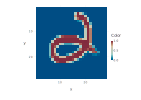

In [126]:
import Gadfly: spy
test_set_size = 10000
temp = 1
temp_pred = 0

while true
    index = rand(1:test_set_size)
    x = Variable(testX[:,:,index], name="x")
    y = Variable(testY[index], name="y")
    result = predict(x, W1, W2, W3)
    exact_prediction = forward!(result) # zwraca przybliżoną wartość do zgadywanej, czyli np 1.1 dla 1
    if Int64(round(first(exact_prediction))) != testY[index]
        temp = index
        temp_pred = Int64(round(first(exact_prediction)))
        break
    end
end

label = testY[temp]
println("Predicted number was labeled as: $label. CNN predicted it was: $temp_pred.")
b = testX[:,:,temp];
spy(b)